# Setup

In [1]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-11-openjdk-amd64/bin/java
!java -version

openjdk version "11.0.14" 2022-01-18
OpenJDK Runtime Environment (build 11.0.14+9-post-Debian-1deb10u1)
OpenJDK 64-Bit Server VM (build 11.0.14+9-post-Debian-1deb10u1, mixed mode, sharing)


In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
spark = SparkSession.builder \
  .appName('Optimize BigQuery Storage') \
  .config('spark.jars.packages', 'com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.24.2,graphframes:graphframes:0.8.1-spark3.0-s_2.12') \
  .getOrCreate()
bucket = "cs777-big-data"
spark.conf.set('temporaryGcsBucket', bucket)

:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.google.cloud.spark#spark-bigquery-with-dependencies_2.12 added as a dependency
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-bf64cd6d-a976-4c04-8afb-adad5d203270;1.0
	confs: [default]
	found com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.24.2 in central
	found graphframes#graphframes;0.8.1-spark3.0-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 246ms :: artifacts dl 8ms
	:: modules in use:
	com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.24.2 from central in [default]
	graphframes#graphframes;0.8.1-spark3.0-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts  

In [3]:
patent = spark.read.format('com.google.cloud.spark.bigquery') \
  .option('table', 'cs777-big-data-346600.patentsview1.patent') \
  .load()
patent.createOrReplaceTempView('patent')

In [4]:
# patent.show(5)

In [5]:
# spark.sql('''
# SELECT YEAR(date) AS year, COUNT(*) as count from patent GROUP BY YEAR(date) ORDER BY YEAR(date) DESC''').show(5)

In [6]:
uspatentcitation = spark.read.format('com.google.cloud.spark.bigquery') \
  .option('table', 'cs777-big-data-346600.patentsview1.uspatentcitation') \
  .load()
uspatentcitation.createOrReplaceTempView('uspatentcitation')
patent_assignee = spark.read.format('com.google.cloud.spark.bigquery') \
  .option('table', 'cs777-big-data-346600.patentsview1.patent_assignee') \
  .load()
patent_assignee.createOrReplaceTempView('patent_assignee')
# patent_assignee.show(5)
patent_assignee.printSchema()
assignee = spark.read.format('com.google.cloud.spark.bigquery') \
  .option('table', 'cs777-big-data-346600.patentsview1.assignee') \
  .load()
assignee.createOrReplaceTempView('assignee')
# assignee.show(5)
assignee.printSchema()

root
 |-- patent_id: string (nullable = true)
 |-- assignee_id: string (nullable = true)
 |-- location_id: string (nullable = true)

root
 |-- id: string (nullable = true)
 |-- type: double (nullable = true)
 |-- name_first: string (nullable = true)
 |-- name_last: string (nullable = true)
 |-- organization: string (nullable = true)



In [7]:
# Extracting graph edges and vertices

In [9]:
edges = spark.sql("""
SELECT 
assignee.organization AS src,
assignee_2.organization AS dst,
count(*) AS count
   
   FROM uspatentcitation AS us_patent_citation
   JOIN patent_assignee AS patent_assignee
   ON us_patent_citation.patent_id = patent_assignee.patent_id
   JOIN patent_assignee AS patent_assignee_2
   ON us_patent_citation.citation_id = patent_assignee_2.patent_id
   JOIN assignee AS assignee
   ON patent_assignee.assignee_id = assignee.id
   JOIN assignee AS assignee_2
   ON patent_assignee_2.assignee_id = assignee_2.id
   WHERE us_patent_citation.date between '2012-01-01' and '2022-04-28'
   AND assignee.organization IS NOT NULL AND assignee_2.organization is NOT NULL
   AND assignee.organization != assignee_2.organization
   AND patent_assignee.assignee_id IN
   
   (SELECT patent_assignee.assignee_id
    FROM patent_assignee AS patent_assignee
    JOIN patent AS us_patent
    ON us_patent.id = patent_assignee.patent_id
    WHERE us_patent.date between '2012-01-01' and '2022-04-28'
    GROUP BY patent_assignee.assignee_id ORDER BY COUNT(patent_assignee.assignee_id) DESC LIMIT  100)
    AND patent_assignee.assignee_id IN
     
    (SELECT patent_assignee.assignee_id
     FROM patent_assignee AS patent_assignee
     JOIN patent AS us_patent
     ON us_patent.id = patent_assignee.patent_id
     WHERE us_patent.date between '2012-01-01' and '2022-04-28'
     GROUP BY patent_assignee.assignee_id ORDER BY COUNT(patent_assignee.assignee_id) DESC LIMIT  100)
     

     GROUP BY patent_assignee.assignee_id,assignee.organization,patent_assignee_2.assignee_id,assignee_2.organization
     ORDER BY count DESC LIMIT 100
""")
edges.createOrReplaceTempView('edges')
# edges.show(100)

In [26]:
edges.show(100)

+--------------------+--------------------+-----+
|                 src|                 dst|count|
+--------------------+--------------------+-----+
|        Covidien LLP|ETHICON ENDO-SURG...|18598|
|        Covidien LLP|Tyco Healthcare G...|18271|
|SAMSUNG ELECTRONI...| LG ELECTRONICS INC.|15819|
|          APPLE INC.|SAMSUNG ELECTRONI...|14147|
|          APPLE INC.|Microsoft Technol...|14052|
|          APPLE INC.|          Google LLC|11804|
| LG ELECTRONICS INC.|SAMSUNG ELECTRONI...|10763|
|SAMSUNG ELECTRONI...|Microsoft Technol...|10278|
|          Google LLC|Microsoft Technol...| 8391|
|SAMSUNG ELECTRONI...|          APPLE INC.| 8326|
|Microsoft Technol...|          Google LLC| 6582|
|          Google LLC|SAMSUNG ELECTRONI...| 6325|
|International Bus...|Microsoft Technol...| 6228|
|International Bus...|          Google LLC| 6141|
|Ford Global Techn...|GM GLOBAL TECHNOL...| 5165|
|          Google LLC|          APPLE INC.| 5088|
|Amazon Technologi...|SkyBell Technolog...| 4831|


In [10]:
vertex = spark.sql("""
(SELECT
assignee.organization as id
   FROM uspatentcitation AS us_patent_citation
   JOIN patent_assignee AS patent_assignee
   ON us_patent_citation.patent_id = patent_assignee.patent_id
   JOIN patent_assignee AS patent_assignee_2
   ON us_patent_citation.citation_id = patent_assignee_2.patent_id
   JOIN assignee AS assignee
   ON patent_assignee.assignee_id = assignee.id
   JOIN assignee AS assignee_2
   ON patent_assignee_2.assignee_id = assignee_2.id
   WHERE us_patent_citation.date between '2012-01-01' and '2022-04-28'
   AND assignee.organization IS NOT NULL AND assignee_2.organization is NOT NULL
   AND assignee.organization != assignee_2.organization
   AND patent_assignee.assignee_id IN
   
   (SELECT patent_assignee.assignee_id
    FROM patent_assignee AS patent_assignee
    JOIN patent AS us_patent
    ON us_patent.id = patent_assignee.patent_id
    WHERE us_patent.date between '2012-01-01' and '2022-04-28'
    GROUP BY patent_assignee.assignee_id ORDER BY COUNT(patent_assignee.assignee_id) DESC LIMIT  100)
    AND patent_assignee.assignee_id IN
     
    (SELECT patent_assignee.assignee_id
     FROM patent_assignee AS patent_assignee
     JOIN patent AS us_patent
     ON us_patent.id = patent_assignee.patent_id
     WHERE us_patent.date between '2012-01-01' and '2022-04-28'
     GROUP BY patent_assignee.assignee_id ORDER BY COUNT(patent_assignee.assignee_id) DESC LIMIT  100)

     GROUP BY patent_assignee.assignee_id,assignee.organization,patent_assignee_2.assignee_id,assignee_2.organization
      LIMIT 100)
UNION
(SELECT 
assignee_2.organization AS organization
   
   FROM uspatentcitation AS us_patent_citation
   JOIN patent_assignee AS patent_assignee
   ON us_patent_citation.patent_id = patent_assignee.patent_id
   JOIN patent_assignee AS patent_assignee_2
   ON us_patent_citation.citation_id = patent_assignee_2.patent_id
   JOIN assignee AS assignee
   ON patent_assignee.assignee_id = assignee.id
   JOIN assignee AS assignee_2
   ON patent_assignee_2.assignee_id = assignee_2.id
   WHERE us_patent_citation.date between '2012-01-01' and '2022-04-28'
   AND assignee.organization IS NOT NULL AND assignee_2.organization is NOT NULL
   AND assignee.organization != assignee_2.organization
   AND patent_assignee.assignee_id IN
   
   (SELECT patent_assignee.assignee_id
    FROM patent_assignee AS patent_assignee
    JOIN patent AS us_patent
    ON us_patent.id = patent_assignee.patent_id
    WHERE us_patent.date between '2012-01-01' and '2022-04-28'
    GROUP BY patent_assignee.assignee_id ORDER BY COUNT(patent_assignee.assignee_id) DESC LIMIT  100)
    AND patent_assignee.assignee_id IN
     
    (SELECT patent_assignee.assignee_id
     FROM patent_assignee AS patent_assignee
     JOIN patent AS us_patent
     ON us_patent.id = patent_assignee.patent_id
     WHERE us_patent.date between '2012-01-01' and '2022-04-28'
     GROUP BY patent_assignee.assignee_id ORDER BY COUNT(patent_assignee.assignee_id) DESC LIMIT  100)

     GROUP BY patent_assignee.assignee_id,assignee.organization,patent_assignee_2.assignee_id,assignee_2.organization
      LIMIT 100
      )
""")


In [27]:
vertex.show(5)

+--------------------+
|                  id|
+--------------------+
|Ford Global Techn...|
|Cisco Technology,...|
|    SONY CORPORATION|
|Honeywell Interna...|
|     NEC CORPORATION|
+--------------------+
only showing top 5 rows



# Graph Analysis

In [15]:
from graphframes import GraphFrame
graph = GraphFrame(vertex, edges).dropIsolatedVertices()

In [ ]:
# graph.vertices.show(100)

In [ ]:
# graph.edges.show(100)

In [12]:
import numpy as np

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
def plot_graph(g : GraphFrame):
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pandasDF = g.edges.toPandas()

    G = nx.from_pandas_edgelist(pandasDF, 'src', 'dst',edge_attr=True,
                            create_using=nx.DiGraph())
    edge = [(u, v) for (u, v, d) in G.edges(data=True)]

    pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=100)

    # edges
    nx.draw_networkx_edges(
        G, pos, edgelist=edge, width=6, alpha=0.5, edge_color="b", style="dashed", arrows=True
    )
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("graph.png",bbox_inches="tight")
    plt.show()

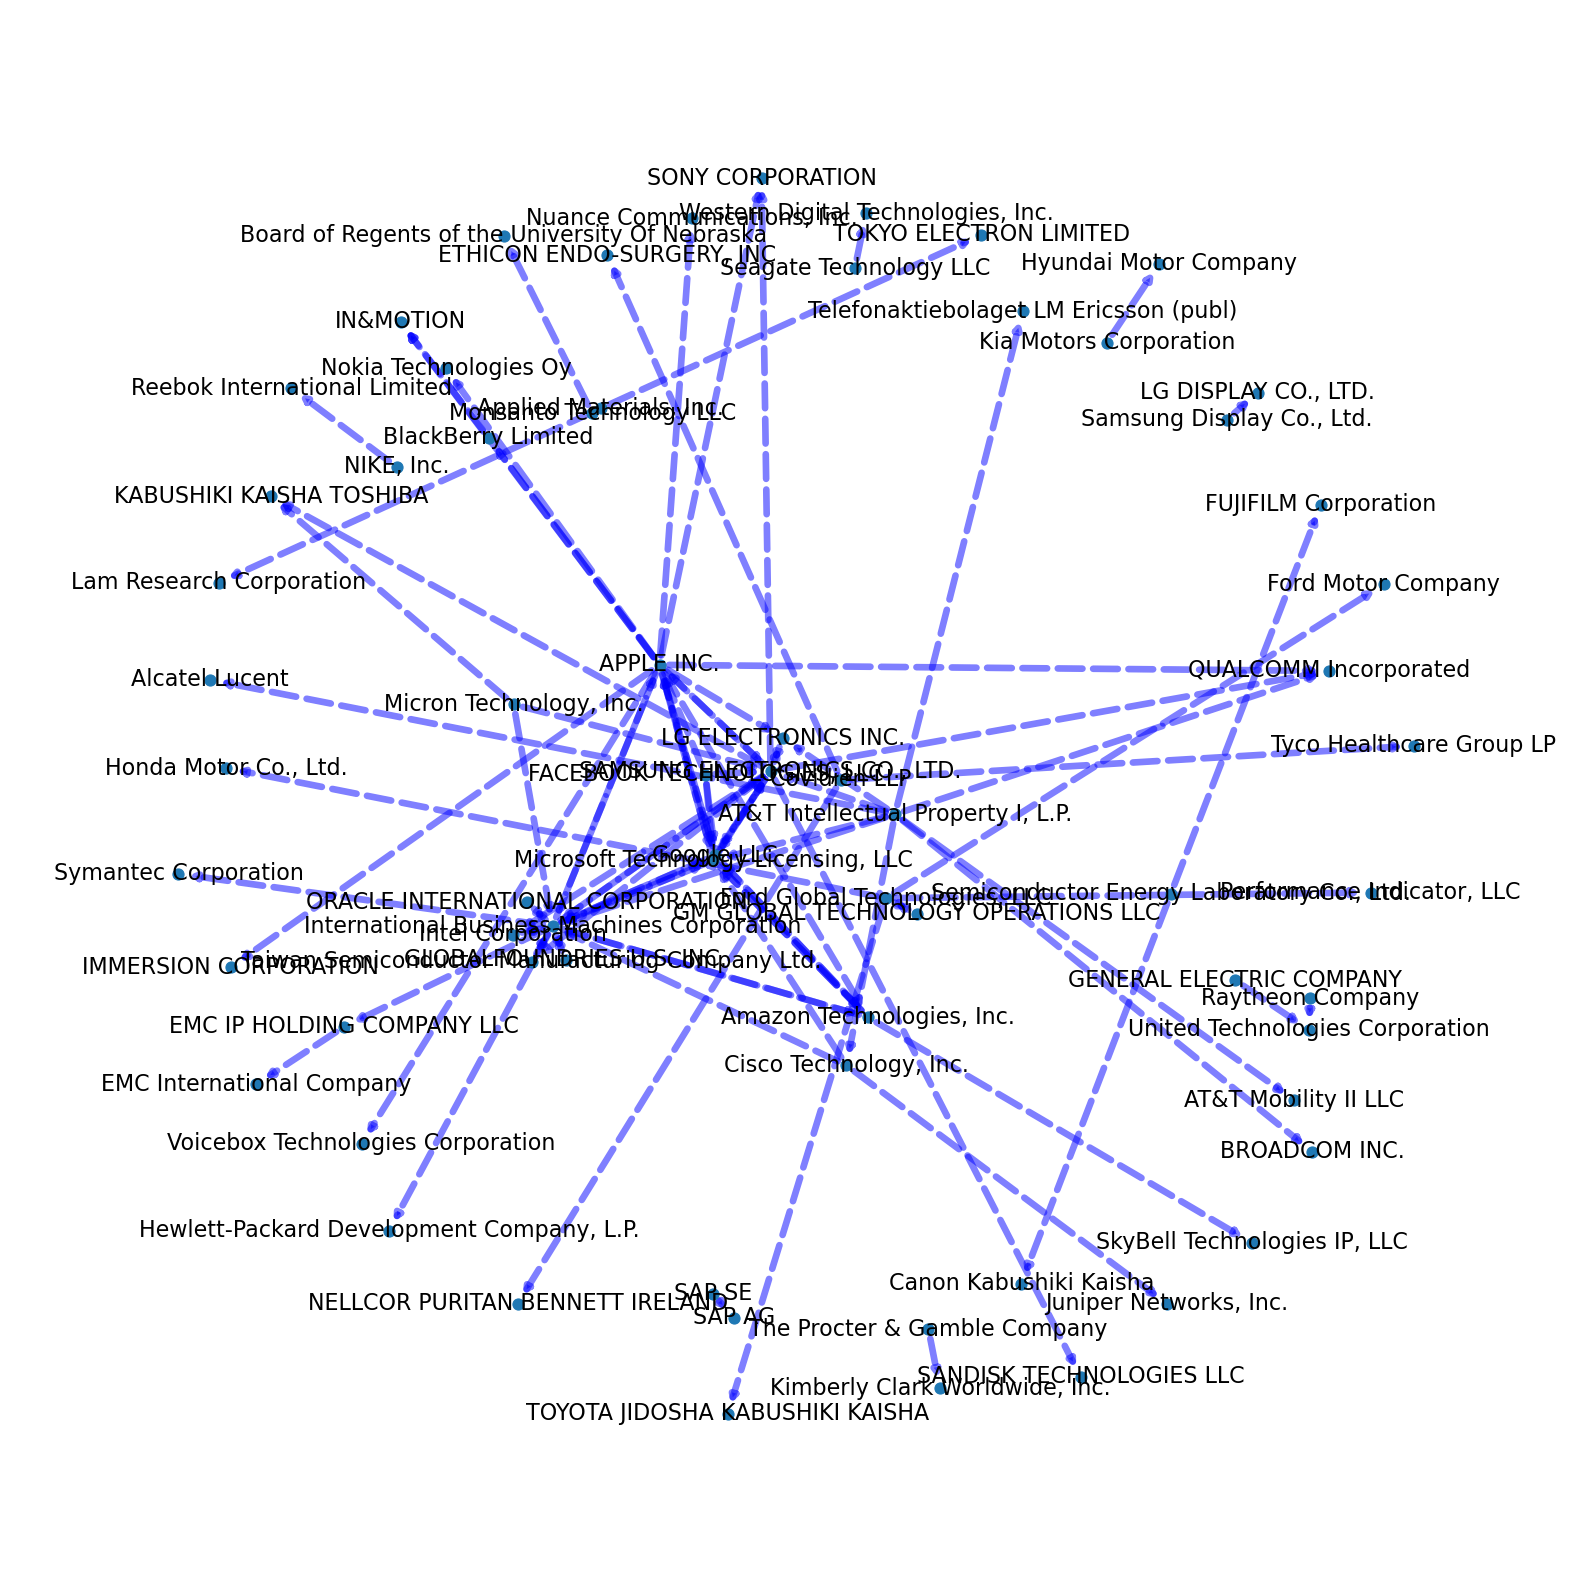

In [13]:
plot_graph(graph) 

In [17]:
spark.sparkContext.setCheckpointDir('./checkpoints')

22/04/28 21:36:09 WARN org.apache.spark.SparkContext: Spark is not running in local mode, therefore the checkpoint directory must not be on the local filesystem. Directory './checkpoints' appears to be on the local filesystem.


In [18]:
graph.connectedComponents().show(100)

+--------------------+-------------+
|                  id|    component|
+--------------------+-------------+
|    SONY CORPORATION|  60129542144|
|Hyundai Motor Com...| 206158430208|
|Ford Global Techn...|  42949672960|
|Cisco Technology,...|  60129542144|
|        Covidien LLP| 240518168576|
|Amazon Technologi...|  60129542144|
|GM GLOBAL TECHNOL...|  42949672960|
|SAMSUNG ELECTRONI...|  60129542144|
|Taiwan Semiconduc...| 575525617664|
|QUALCOMM Incorpor...|  60129542144|
|          APPLE INC.|  60129542144|
|          Google LLC|  60129542144|
|Micron Technology...|  60129542144|
|International Bus...|  60129542144|
|Microsoft Technol...|  60129542144|
|Hewlett-Packard D...|  60129542144|
|GENERAL ELECTRIC ...|1554778161152|
|Honda Motor Co., ...|1597727834112|
|Canon Kabushiki K...|1606317768704|
|   Intel Corporation|  60129542144|
|KABUSHIKI KAISHA ...|  60129542144|
+--------------------+-------------+



In [19]:
graph.stronglyConnectedComponents(maxIter=10)\
    .orderBy('component').show(100)

+--------------------+-------------+
|                  id|    component|
+--------------------+-------------+
|Ford Global Techn...|  42949672960|
|GM GLOBAL TECHNOL...|  42949672960|
|Cisco Technology,...|  60129542144|
|    SONY CORPORATION|  85899345920|
|Hyundai Motor Com...| 206158430208|
|Seagate Technolog...| 274877906944|
|Microsoft Technol...| 360777252864|
|GLOBALFOUNDRIES U...| 360777252864|
|Amazon Technologi...| 360777252864|
|SAMSUNG ELECTRONI...| 360777252864|
|          Google LLC| 360777252864|
|   Intel Corporation| 360777252864|
|International Bus...| 360777252864|
|          APPLE INC.| 360777252864|
|AT&T Intellectual...| 833223655424|
|ORACLE INTERNATIO...| 841813590016|
|QUALCOMM Incorpor...| 979252543488|
|Micron Technology...|1099511627776|
|Hewlett-Packard D...|1468878815232|
|GENERAL ELECTRIC ...|1554778161152|
|Canon Kabushiki K...|1606317768704|
|KABUSHIKI KAISHA ...|1623497637888|
+--------------------+-------------+



In [20]:
results = graph.pageRank(resetProbability=0.15, tol=0.01)
results

GraphFrame(v:[id: string, pagerank: double], e:[src: string, dst: string ... 2 more fields])

In [21]:
results.vertices.select("id", "pagerank")\
    .orderBy('pagerank', ascending = False).show(100)

+--------------------+-------------------+
|                  id|           pagerank|
+--------------------+-------------------+
|International Bus...| 4.3556049743963925|
|Microsoft Technol...|  2.168069003103119|
|          Google LLC| 1.9637100988046168|
|SAMSUNG ELECTRONI...| 1.8266083260436967|
|Amazon Technologi...| 1.6641625218383533|
|          APPLE INC.| 1.6384754530683554|
|Ford Global Techn...| 0.9889152510728962|
|QUALCOMM Incorpor...| 0.7840508010367049|
|Honda Motor Co., ...| 0.7786253145118852|
|Hewlett-Packard D...| 0.7688862126405769|
|KABUSHIKI KAISHA ...| 0.6294200718761435|
|Cisco Technology,...|0.41925350938290795|
|Micron Technology...| 0.3583363328059042|
|Canon Kabushiki K...| 0.3583363328059042|
|ORACLE INTERNATIO...| 0.3583363328059042|
|GENERAL ELECTRIC ...| 0.3583363328059042|
|AT&T Intellectual...| 0.3583363328059042|
|Hyundai Motor Com...| 0.3583363328059042|
|Applied Materials...| 0.3583363328059042|
|Seagate Technolog...| 0.3583363328059042|
+----------

In [22]:
motifs = graph.find("(a)-[e1]->(b); (b)-[e2]->(a)")

In [23]:
motifs.show(100)

+--------------------+--------------------+--------------------+--------------------+
|                   a|                  e1|                   b|                  e2|
+--------------------+--------------------+--------------------+--------------------+
|{SAMSUNG ELECTRON...|{SAMSUNG ELECTRON...|{LG ELECTRONICS I...|{LG ELECTRONICS I...|
|        {APPLE INC.}|{APPLE INC., SAMS...|{SAMSUNG ELECTRON...|{SAMSUNG ELECTRON...|
|        {APPLE INC.}|{APPLE INC., Micr...|{Microsoft Techno...|{Microsoft Techno...|
|        {APPLE INC.}|{APPLE INC., Goog...|        {Google LLC}|{Google LLC, APPL...|
|{LG ELECTRONICS I...|{LG ELECTRONICS I...|{SAMSUNG ELECTRON...|{SAMSUNG ELECTRON...|
|{SAMSUNG ELECTRON...|{SAMSUNG ELECTRON...|{Microsoft Techno...|{Microsoft Techno...|
|        {Google LLC}|{Google LLC, Micr...|{Microsoft Techno...|{Microsoft Techno...|
|{SAMSUNG ELECTRON...|{SAMSUNG ELECTRON...|        {APPLE INC.}|{APPLE INC., SAMS...|
|{Microsoft Techno...|{Microsoft Techno...|        {Go

In [24]:
one_direction_motifs = graph.find("(a)-[e1]->(b); !(b)-[]->(a)").orderBy("a.id")

In [25]:
one_direction_motifs.show(100)

+--------------------+--------------------+--------------------+
|                   a|                  e1|                   b|
+--------------------+--------------------+--------------------+
|        {APPLE INC.}|{APPLE INC., QUAL...|{QUALCOMM Incorpo...|
|        {APPLE INC.}|{APPLE INC., Amaz...|{Amazon Technolog...|
|        {APPLE INC.}|{APPLE INC., LG E...|{LG ELECTRONICS I...|
|        {APPLE INC.}|{APPLE INC., Noki...|{Nokia Technologi...|
|{AT&T Intellectua...|{AT&T Intellectua...|{LG ELECTRONICS I...|
|{AT&T Intellectua...|{AT&T Intellectua...|{Cisco Technology...|
|{AT&T Intellectua...|{AT&T Intellectua...|{International Bu...|
|{AT&T Intellectua...|{AT&T Intellectua...|{Microsoft Techno...|
|{AT&T Intellectua...|{AT&T Intellectua...|{QUALCOMM Incorpo...|
|{AT&T Intellectua...|{AT&T Intellectua...|{SAMSUNG ELECTRON...|
|{AT&T Intellectua...|{AT&T Intellectua...|     {BROADCOM INC.}|
|{Cisco Technology...|{Cisco Technology...|{International Bu...|
|{Cisco Technology...|{Ci

In [48]:
Top_100_df = spark.sql("""
SELECT patent_assignee.assignee_id as assignee_id,
assignee.organization as assignee,
patent_assignee_2.assignee_id as cited_assignee_id,
assignee_2.organization as cited_assignee,
count(*) AS citations
   
   FROM uspatentcitation AS us_patent_citation
   JOIN patent_assignee AS patent_assignee
   ON us_patent_citation.patent_id = patent_assignee.patent_id
   JOIN patent_assignee AS patent_assignee_2
   ON us_patent_citation.citation_id = patent_assignee_2.patent_id
   JOIN assignee AS assignee
   ON patent_assignee.assignee_id = assignee.id
   JOIN assignee AS assignee_2
   ON patent_assignee_2.assignee_id = assignee_2.id
   WHERE us_patent_citation.date between '1980-01-01' and '1989-12-31'
   AND patent_assignee.assignee_id IN
   
   (SELECT patent_assignee.assignee_id
    FROM patent_assignee AS patent_assignee
    JOIN patent AS us_patent
    ON us_patent.id = patent_assignee.patent_id
    WHERE us_patent.date between '1980-01-01' and '1989-12-31'
    GROUP BY patent_assignee.assignee_id ORDER BY COUNT(patent_assignee.assignee_id) DESC LIMIT  100)
    AND patent_assignee.assignee_id IN
     
    (SELECT patent_assignee.assignee_id
     FROM patent_assignee AS patent_assignee
     JOIN patent AS us_patent
     ON us_patent.id = patent_assignee.patent_id
     WHERE us_patent.date between '1980-01-01' and '1989-12-31'
     GROUP BY patent_assignee.assignee_id ORDER BY COUNT(patent_assignee.assignee_id) DESC LIMIT  100)

     GROUP BY patent_assignee.assignee_id,assignee.organization,patent_assignee_2.assignee_id,assignee_2.organization
     ORDER BY patent_assignee.assignee_id,citations DESC
""")


In [5]:
#Select top 100 assignee with most number of patent each year
DF_top100_Assignee = spark.sql("""
Select Assignee_id,year, Assignee.organization
From
(Select *,
rank() over(PARTITION BY year order by COUNT DESC) as rank
From
(SELECT patent_assignee.assignee_id,substr(us_patent.date,0,4) as year, COUNT(patent_assignee.assignee_id) as count

    FROM patent_assignee AS patent_assignee
    JOIN patent AS us_patent
    ON us_patent.id = patent_assignee.patent_id
    GROUP BY year,patent_assignee.assignee_id ORDER BY year,COUNT(patent_assignee.assignee_id) DESC)
order by year,rank)
Join Assignee
ON Assignee.id = Assignee_id
Where rank <101
Order by year

""")
DF_top100_Assignee.createOrReplaceTempView('DF_top100_Assignee')
#Select all the abstract within top 100 assignee for each year
Abstract_df = spark.sql("""
Select Abstract,year
From
(Select patent.id As patent_id,patent.abstract as Abstract, substr(patent.date,0,4) As year,
patent_assignee.assignee_id as assignee_id
From patent
Join patent_assignee on patent.id = patent_assignee.patent_id
Join DF_top100_Assignee On patent_assignee.assignee_id = DF_top100_Assignee.assignee_id And year = DF_top100_Assignee.year
Order by year)

""")

Abstract_df.createOrReplaceTempView('All_abstract')

In [21]:
#Abstract text for each year
# Abstract_df.createOrReplaceTempView('All_abstract')

Abstract_2012_22_df = spark.sql("""
Select distinct Abstract
From All_abstract
Where year >= 2012 and year <= 2022
""")

# Abstract_2021 = spark.sql("""
# Select distinct Abstract
# From All_abstract
# Where year = 2021
# """)

# Abstract_2020 = spark.sql("""
# Select distinct Abstract
# From All_abstract
# Where year = 2020
# """)

# Abstract_2019 = spark.sql("""
# Select distinct Abstract
# From All_abstract
# Where year = 2019
# """)

# Abstract_2018 = spark.sql("""
# Select distinct Abstract
# From All_abstract
# Where year = 2018
# """)

# Abstract_2017 = spark.sql("""
# Select distinct Abstract
# From All_abstract
# Where year = 2017
# """)

# Abstract_2016 = spark.sql("""
# Select distinct Abstract
# From All_abstract
# Where year = 2016
# """)

# Abstract_2015 = spark.sql("""
# Select distinct Abstract
# From All_abstract
# Where year = 2015
# """)

# Abstract_2014 = spark.sql("""
# Select distinct Abstract
# From All_abstract
# Where year = 2014
# """)

# Abstract_2013 = spark.sql("""
# Select distinct Abstract
# From All_abstract
# Where year = 2013
# """)

# Abstract_2012 = spark.sql("""
# Select distinct Abstract
# From All_abstract
# Where year = 2012
# """)

In [23]:
#pip install --upgrade nltk

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#Text modeling
#https://medium.com/trustyou-engineering/topic-modelling-with-pyspark-and-spark-nlp-a99d063f1a6e


from pyspark.ml.feature import Tokenizer, RegexTokenizer, CountVectorizer, \
           StopWordsRemover, NGram, HashingTF, IDF, Word2Vec

from pyspark.sql.functions import explode, expr
from pyspark.ml.functions  import vector_to_array
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import IDF
from pyspark.sql import functions as F
#preprocess the text for topic modelling purposes
Abstract_text = Abstract_2012_22_df.select('Abstract')


#transform data to annotation format
from sparknlp.base import DocumentAssembler
documentAssembler = DocumentAssembler().setInputCol('Abstract').setOutputCol('Document')

#split sentences into words
from sparknlp.annotator import Tokenizer
tokenizer = Tokenizer().setInputCols(['Document']).setOutputCol('Tokenized')

#clean the data and perform lowercasing
from sparknlp.annotator import Normalizer
normalizer = Normalizer().setInputCols(['Tokenized']).setOutputCol('Normalized').setLowercase(True)


#all words in the data to its lemma (base form)
from sparknlp.annotator import LemmatizerModel
lemmatizer = LemmatizerModel.pretrained().setInputCols(['Normalized']).setOutputCol('Lemmatized')

#filter stop words out left only  meaningful words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stops = stopwords.words('english')

from sparknlp.annotator import StopWordsCleaner
stopwords_cleaner = StopWordsCleaner().setInputCols(['Lemmatized']).setOutputCol('no_stop_lemmatized').setStopWords(stops)

from sparknlp.annotator import PerceptronModel
pos_tagger = PerceptronModel.pretrained('pos_anc').setInputCols(['Document', 'Lemmatized']).setOutputCol('pos')

from sparknlp.annotator import Chunker
allowed_tags = ['<JJ>+<NN>', '<NN>+<NN>']
chunker = Chunker().setInputCols(['Document', 'pos']).setOutputCol('ngrams').setRegexParsers(allowed_tags)

from sparknlp.base import Finisher
finisher = Finisher().setInputCols(['no_stop_lemmatized','ngrams'])

from pyspark.ml import Pipeline
pipeline = Pipeline().setStages([documentAssembler,
                 tokenizer,
                 normalizer,
                 lemmatizer,
                 stopwords_cleaner,
                 pos_tagger,
                 chunker,
                 finisher])


processed_abstract = pipeline.fit(Abstract_text).transform(Abstract_text)



from pyspark.sql.functions import concat
processed_abstract = processed_abstract.withColumn('final',
     concat('finished_no_stop_lemmatized', 
            'finished_ngrams'))

from pyspark.ml.feature import CountVectorizer
tfizer = CountVectorizer(inputCol='finished_no_stop_lemmatized',
                         outputCol='tf_features')
tf_model = tfizer.fit(processed_abstract)
tf_result = tf_model.transform(processed_abstract)

from pyspark.ml.feature import IDF
idfizer = IDF(inputCol='tf_features', 
              outputCol='tf_idf_features')
idf_model = idfizer.fit(tf_result)
tfidf_result = idf_model.transform(tf_result)

from pyspark.ml.clustering import LDA
num_topics = 50
max_iter = 10
lda = LDA(k=num_topics, 
          maxIter=max_iter, 
          featuresCol='tf_idf_features')
lda_model = lda.fit(tfidf_result)

vocab = tf_model.vocabulary
def get_words(token_list):
    return [vocab[token_id] for token_id in token_list]
udf_to_words = F.udf(get_words)

num_top_words = 7
topics = lda_model.describeTopics(num_top_words).withColumn('topicWords', udf_to_words(F.col('termIndices')))
topics.select('topic', 'topicWords').show(truncate=100)


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ]lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
Download done! Loading the resource.
[ / ]

[OK!]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[ | ]pos_anc download started this may take some time.
Approximate size to download 3.9 MB
Download done! Loading the resource.
[ / ]

[OK!]


22/04/28 21:14:21 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.6 MiB
ERROR:root:KeyboardInterrupt while sending command.                 (4 + 3) / 7]
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/py4j/clientserver.py", line 475, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/miniconda3/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [20]:
tokenizer = Tokenizer(inputCol="Abstract", 
                      outputCol="words")
wordsData = tokenizer.transform(Abstract_text)
remover = StopWordsRemover(inputCol="words", 
                           outputCol="filteredWords")
noStopWordsDF = remover.transform(wordsData)

cv = CountVectorizer(inputCol="filteredWords", 
                     outputCol="rawFeatures", 
                     vocabSize=100, minDF=1)

noStopWordsDF.show(5)

+--------------------+--------------------+--------------------+
|            Abstract|               words|       filteredWords|
+--------------------+--------------------+--------------------+
|An organic light ...|[an, organic, lig...|[organic, light, ...|
|Crystalline forms...|[crystalline, for...|[crystalline, for...|
|An accelerometer ...|[an, acceleromete...|[accelerometer, m...|
|An email content ...|[an, email, conte...|[email, content, ...|
|Embodiments of th...|[embodiments, of,...|[embodiments, pre...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer, CountVectorizer, \
           StopWordsRemover, NGram, HashingTF, IDF, Word2Vec

from pyspark.sql.functions import explode, expr
from pyspark.ml.functions  import vector_to_array
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import IDF
from pyspark.sql import functions as F
#Text modeling

Abstract_text = Abstract_2012_22_df.select('Abstract')

tokenizer = Tokenizer(inputCol="Abstract", 
                      outputCol="words")
wordsData = tokenizer.transform(Abstract_text)


remover = StopWordsRemover(inputCol="words", 
                           outputCol="filteredWords")

noStopWordsDF = remover.transform(wordsData)

cv = CountVectorizer(inputCol="filteredWords", 
                     outputCol="rawFeatures", 
                     vocabSize=100, minDF=2)

model = cv.fit(noStopWordsDF)

result = model.transform(noStopWordsDF)


lda = LDA(k=50, 
          maxIter=10, 
          seed=1,
          featuresCol="rawFeatures")

lda_model = lda.fit(result)

idfizer = IDF(inputCol='rawFeatures', 
              outputCol='idf_rawFeatures')
idf_model = idfizer.fit(result)
idf_result = idf_model.transform(result)


vocab = model.vocabulary
def get_words(token_list):
    return [vocab[token_id] for token_id in token_list]

udf_to_words = F.udf(get_words)


topics = lda_model.describeTopics(5).withColumn('topicWords', udf_to_words(F.col('termIndices')))
        
topics.select('topic', 'topicWords').show(30,truncate=100)

# Number of patents published each year


In [7]:
# Number of patents published each year
patents_each_year = spark.sql('''
SELECT YEAR(date) AS year, COUNT(*) as count from patent GROUP BY YEAR(date) ORDER BY YEAR(date) DESC''').toPandas()
# patents_each_year.show(5)

<AxesSubplot:xlabel='YEAR', ylabel='COUNT'>

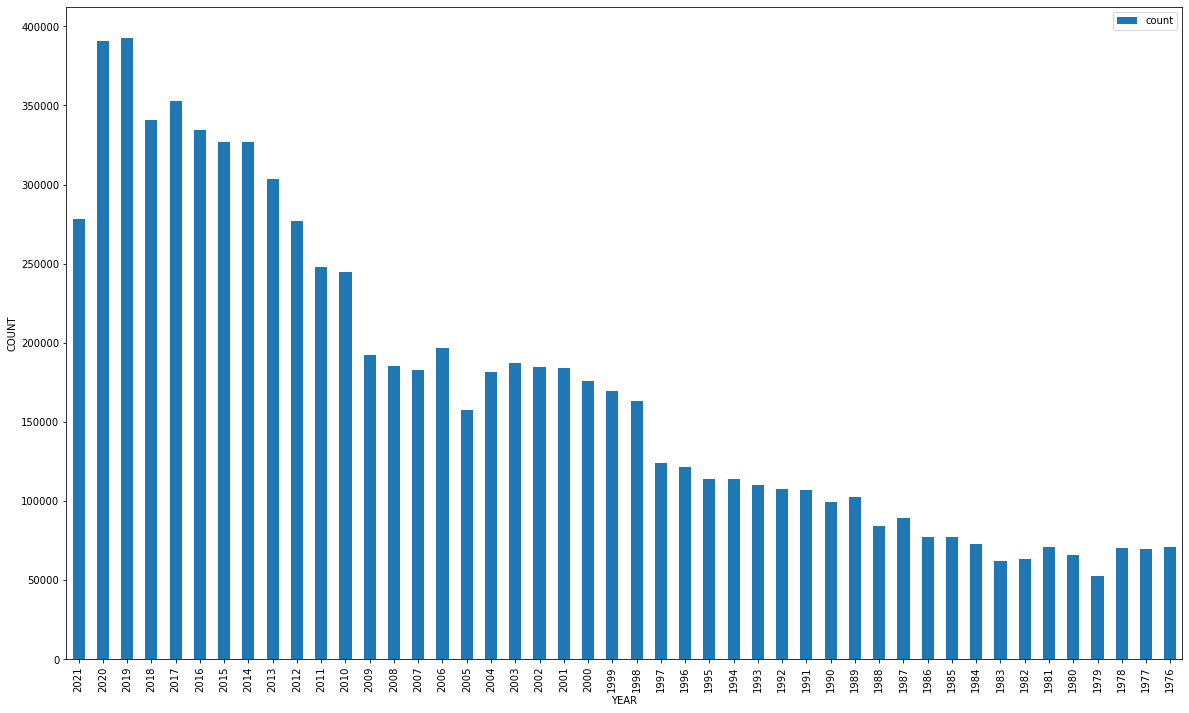

In [8]:
patents_each_year.plot.bar(x='year', y='count', figsize=(20, 12), ylabel = 'COUNT', xlabel = 'YEAR' )

# Consistency of top 2 companies for 2 decades.

In [9]:


top_2_companies_per_year = spark.sql("""
Select organization, year, rank, count
From
(Select *,
rank() over(PARTITION BY year order by COUNT DESC) as rank
From
(SELECT patent_assignee.assignee_id,substr(us_patent.date,0,4) as year, COUNT(patent_assignee.assignee_id) as count

    FROM patent_assignee AS patent_assignee
    JOIN patent AS us_patent
    ON us_patent.id = patent_assignee.patent_id
    GROUP BY year,patent_assignee.assignee_id ORDER BY year,COUNT(patent_assignee.assignee_id) DESC)
order by year,rank)
Join Assignee
ON Assignee.id = Assignee_id
Where rank <=2 and year >= 2010 and year <= 2020
Order by year, rank

""").toPandas()


In [10]:
top_2_companies_per_year

,organization,year,rank,count
0,International Business Machines Corporation,2010,1,5875
1,"SAMSUNG ELECTRONICS CO., LTD.",2010,2,4920
2,International Business Machines Corporation,2011,1,6163
3,"SAMSUNG ELECTRONICS CO., LTD.",2011,2,5214
4,International Business Machines Corporation,2012,1,6448
5,"SAMSUNG ELECTRONICS CO., LTD.",2012,2,5443
6,International Business Machines Corporation,2013,1,6793
7,"SAMSUNG ELECTRONICS CO., LTD.",2013,2,5187
8,International Business Machines Corporation,2014,1,7530
9,"SAMSUNG ELECTRONICS CO., LTD.",2014,2,5824


<AxesSubplot:xlabel='YEAR', ylabel='COUNT'>

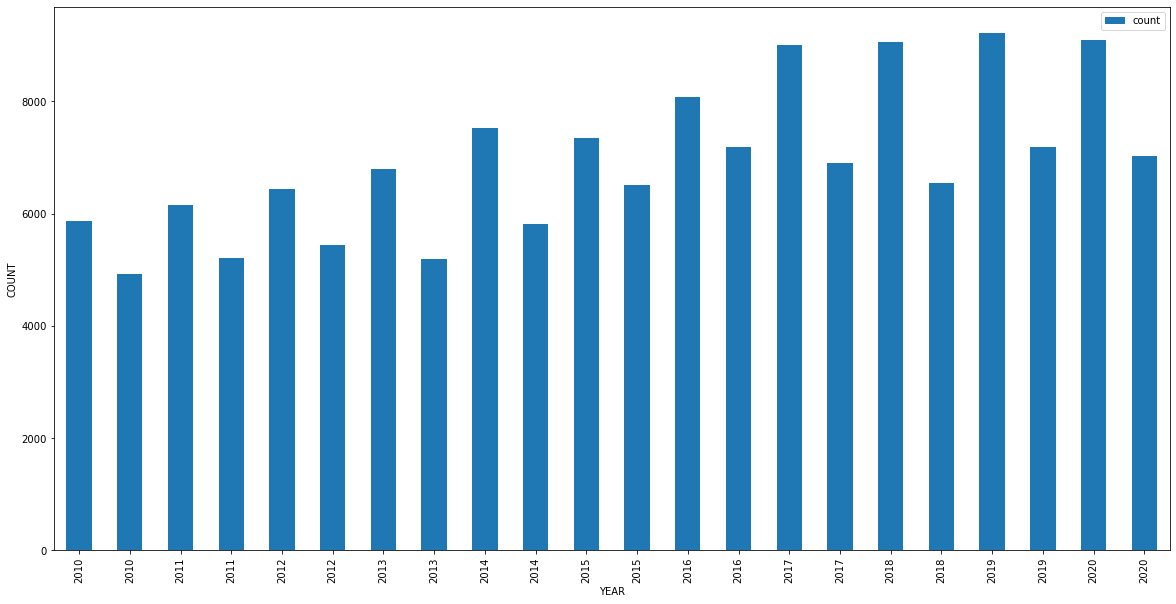

In [11]:
top_2_companies_per_year.plot.bar(x='year',y='count', figsize=(20, 10), ylabel='COUNT', xlabel='YEAR')


# Top 20 companies which are highly dependent on each other in terms of patent.


In [12]:
#Top 20 companies which are highly dependent on each other in terms of patent.

company_dependency = spark.sql("""
SELECT 
assignee.organization AS src,
assignee_2.organization AS dst,
count(*) AS weight
   
   FROM uspatentcitation AS us_patent_citation
   JOIN patent_assignee AS patent_assignee
   ON us_patent_citation.patent_id = patent_assignee.patent_id
   JOIN patent_assignee AS patent_assignee_2
   ON us_patent_citation.citation_id = patent_assignee_2.patent_id
   JOIN assignee AS assignee
   ON patent_assignee.assignee_id = assignee.id
   JOIN assignee AS assignee_2
   ON patent_assignee_2.assignee_id = assignee_2.id
   WHERE us_patent_citation.date between '2012-01-01' and '2022-04-28'
   AND assignee.organization IS NOT NULL AND assignee_2.organization is NOT NULL
   AND assignee.organization != assignee_2.organization
   AND patent_assignee.assignee_id IN
   
   (SELECT patent_assignee.assignee_id
    FROM patent_assignee AS patent_assignee
    JOIN patent AS us_patent
    ON us_patent.id = patent_assignee.patent_id
    WHERE us_patent.date between '2012-01-01' and '2022-04-28'
    GROUP BY patent_assignee.assignee_id ORDER BY COUNT(patent_assignee.assignee_id) DESC LIMIT  100)
    AND patent_assignee.assignee_id IN
     
    (SELECT patent_assignee.assignee_id
     FROM patent_assignee AS patent_assignee
     JOIN patent AS us_patent
     ON us_patent.id = patent_assignee.patent_id
     WHERE us_patent.date between '2012-01-01' and '2022-04-28'
     GROUP BY patent_assignee.assignee_id ORDER BY COUNT(patent_assignee.assignee_id) DESC LIMIT  100)
     

     GROUP BY patent_assignee.assignee_id,assignee.organization,patent_assignee_2.assignee_id,assignee_2.organization
     ORDER BY weight DESC
""").toPandas()

In [13]:
company_dependency

,src,dst,weight
0,Covidien LLP,"ETHICON ENDO-SURGERY, INC",18598
1,Covidien LLP,Tyco Healthcare Group LP,18271
2,"SAMSUNG ELECTRONICS CO., LTD.",LG ELECTRONICS INC.,15819
3,APPLE INC.,"SAMSUNG ELECTRONICS CO., LTD.",14147
4,APPLE INC.,"Microsoft Technology Licensing, LLC",14052
...,...,...,...
171697,"Microsoft Technology Licensing, LLC",Huf Hülsbeck & Fürst GmbH & Co. KG,1
171698,INDUSTRIAL TECHNOLOGY RESEARCH INSTITUTE,NATIONAL TAIWAN NORMAL UNIVERSITY,1
171699,Robert Bosch GmbH,"Norwalt Design, Inc.",1
171700,Robert Bosch GmbH,"Ample, Inc.",1


In [14]:
company_dependency['pair'] = company_dependency.apply(lambda row: row['src'] + '-' + row['dst'], axis = 1)

<AxesSubplot:ylabel='pair'>

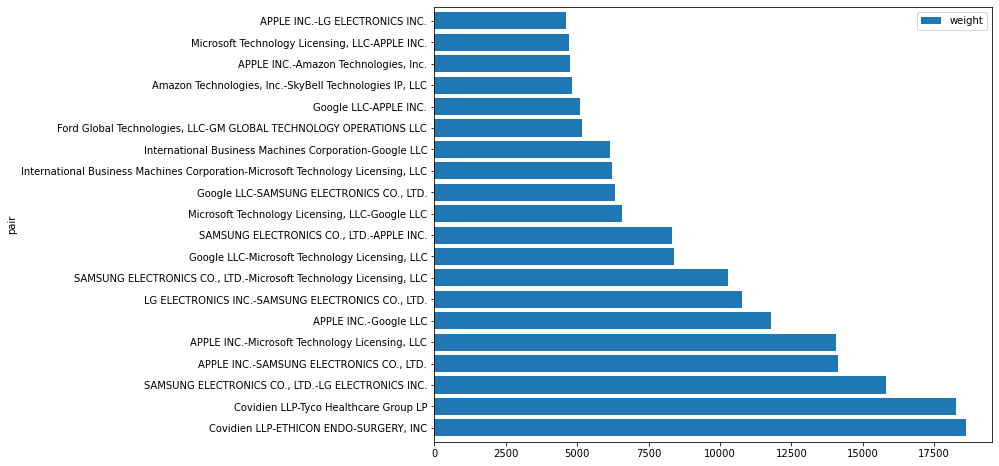

In [15]:
company_dependency[:20].plot.barh(x='pair',y='weight', width =0.8, figsize=(10, 8))

In [16]:
X=Top_100_df.select("*")
Top_100_df_pandas=X.toPandas()

In [17]:
Top_100_df_pandas1=Top_100_df_pandas[:10]

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

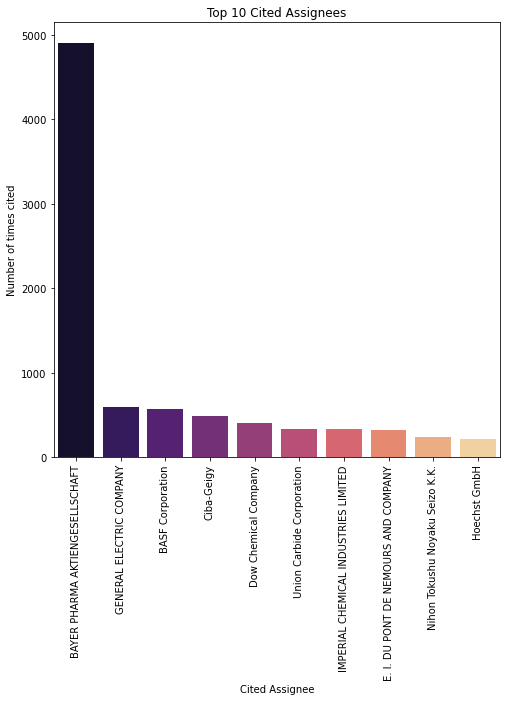

In [19]:
fig, ax = plt.subplots(figsize =(8,8))
c = sns.barplot(data=Top_100_df_pandas1, y='citations', x='cited_assignee', palette='magma')
c.set(xlabel='Cited Assignee', ylabel='Number of times cited', title='Top 10 Cited Assignees')
plt.xticks(rotation=90);

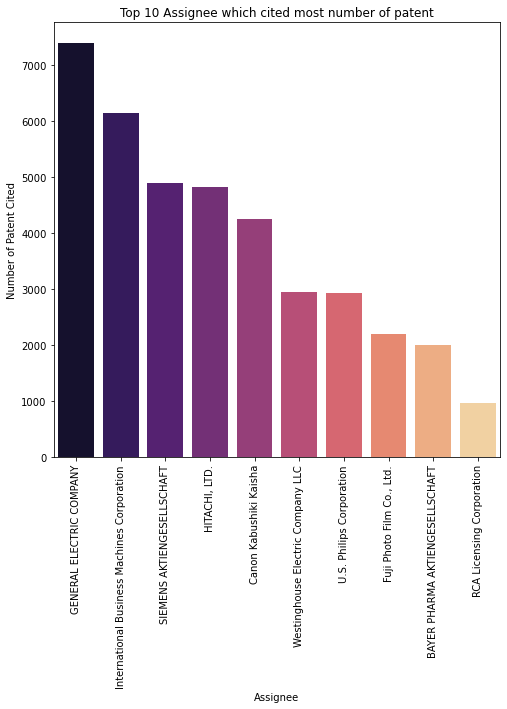

In [20]:
##Counting Drug based on Label
f = Top_100_df_pandas.groupby(['assignee'])['citations'].count().sort_values(ascending=False).head(10)
f = f.reset_index()

##Plotting the Top 10 Drugs with labels
fig, ax = plt.subplots(figsize =(8,8))
c = sns.barplot(data=f, y='citations', x='assignee', palette='magma')
c.set(xlabel='Assignee', ylabel='Number of Patent Cited', title='Top 10 Assignee which cited most number of patent')
plt.xticks(rotation=90);

In [21]:
patent2=patent.select('*')
patent2=patent2.withColumnRenamed('type','Cited_patent_type')
patent2=patent2.withColumnRenamed('date','Cited_patent_publish_date')
patent2=patent2.withColumnRenamed('title','Cited_patent_title')
patent2=patent2.withColumnRenamed('id','Cited_patent_id')
patent2.show(2)

+---------------+-----------------+--------+-------+-------------------------+--------------------+--------------------+----+----------+-------------+---------+
|Cited_patent_id|Cited_patent_type|  number|country|Cited_patent_publish_date|            abstract|  Cited_patent_title|kind|num_claims|     filename|withdrawn|
+---------------+-----------------+--------+-------+-------------------------+--------------------+--------------------+----+----------+-------------+---------+
|       10326040|          utility|10326040|     US|               2019-06-18|Embodiments relat...|Washable mold for...|  B1|        19|ipg190618.xml|        0|
|       10327447|          utility|10327447|     US|               2019-06-25|The invention rel...|Phosphonate funct...|  B2|         8|ipg190625.xml|        0|
+---------------+-----------------+--------+-------+-------------------------+--------------------+--------------------+----+----------+-------------+---------+
only showing top 2 rows



In [22]:
patent_subset=Patent_info.select('patent_id','assignee_id')
patent_subset=patent_subset.withColumnRenamed('assignee_id','assigne_id')
patent_subset.show(1)

+---------+--------------------+
|patent_id|          assigne_id|
+---------+--------------------+
| 10000043|2b25b46d-3d6b-454...|
+---------+--------------------+
only showing top 1 row



In [23]:
Patent_Cited_Info=patent2.join(patent_subset,patent2["Cited_patent_id"] ==  patent_subset["patent_id"],"inner")
Patent_Cited_Info.show(2)

+---------------+-----------------+--------+-------+-------------------------+--------------------+--------------------+----+----------+-------------+---------+---------+--------------------+
|Cited_patent_id|Cited_patent_type|  number|country|Cited_patent_publish_date|            abstract|  Cited_patent_title|kind|num_claims|     filename|withdrawn|patent_id|          assigne_id|
+---------------+-----------------+--------+-------+-------------------------+--------------------+--------------------+----+----------+-------------+---------+---------+--------------------+
|       10000021|          utility|10000021|     US|               2018-06-19|There is provided...|Method for manufa...|  B2|         4|ipg180619.xml|        0| 10000021|fef15985-a42a-46a...|
|       10000108|          utility|10000108|     US|               2018-06-19|A refrigeration c...|Refrigeration cyc...|  B2|         8|ipg180619.xml|        0| 10000108|2f9425f5-a2c6-4b5...|
+---------------+-----------------+-----

In [24]:
Patent_Top10=Top_100_df.join(Patent_Cited_Info,Top_100_df["cited_assignee_id"] ==  Patent_Cited_Info["assigne_id"],"inner").limit(100000)

In [25]:
Patent_Top10.printSchema()

root
 |-- assignee_id: string (nullable = true)
 |-- assignee: string (nullable = true)
 |-- cited_assignee_id: string (nullable = true)
 |-- cited_assignee: string (nullable = true)
 |-- citations: long (nullable = false)
 |-- Cited_patent_id: string (nullable = true)
 |-- Cited_patent_type: string (nullable = true)
 |-- number: string (nullable = true)
 |-- country: string (nullable = true)
 |-- Cited_patent_publish_date: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- Cited_patent_title: string (nullable = true)
 |-- kind: string (nullable = true)
 |-- num_claims: long (nullable = true)
 |-- filename: string (nullable = true)
 |-- withdrawn: long (nullable = true)
 |-- patent_id: string (nullable = true)
 |-- assigne_id: string (nullable = true)



In [26]:
Patent_Top10=Patent_Top10.select('assignee_id', 'assignee','cited_assignee_id','cited_assignee','citations','Cited_patent_id','Cited_patent_type','Cited_patent_publish_date','Cited_patent_title')

In [27]:
Patent_Top10.printSchema()

root
 |-- assignee_id: string (nullable = true)
 |-- assignee: string (nullable = true)
 |-- cited_assignee_id: string (nullable = true)
 |-- cited_assignee: string (nullable = true)
 |-- citations: long (nullable = false)
 |-- Cited_patent_id: string (nullable = true)
 |-- Cited_patent_type: string (nullable = true)
 |-- Cited_patent_publish_date: string (nullable = true)
 |-- Cited_patent_title: string (nullable = true)



In [28]:
#Patent_Top10=Patent_Top10.limit(1000)

In [29]:
Patent_Top10=Patent_Top10.na.drop()
#print((Patent_Top10.count(), len(Patent_Top10.columns)))

In [30]:
#Newdf= Patent_Top10.toPandas()
#Newdf.to_excel('Patent_Top10_final_DF.xlsx', sheet_name = 'Sheet1', index = False) 

In [31]:
import pandas as pd

In [60]:
df=pd.read_excel('Patent_Top10_final_DF.xlsx')

In [61]:
Patent_Top10=spark.createDataFrame(df) 
Patent_Top10.printSchema()

root
 |-- assignee_id: string (nullable = true)
 |-- assignee: string (nullable = true)
 |-- cited_assignee_id: string (nullable = true)
 |-- cited_assignee: string (nullable = true)
 |-- citations: long (nullable = true)
 |-- Cited_patent_id: string (nullable = true)
 |-- Cited_patent_type: string (nullable = true)
 |-- Cited_patent_publish_date: string (nullable = true)
 |-- Cited_patent_title: string (nullable = true)



### One Hot Encoding

In [62]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, IndexToString
stringIndexer = StringIndexer(
    inputCols = ['assignee_id', 'assignee','cited_assignee_id','cited_assignee','Cited_patent_id','Cited_patent_type','Cited_patent_publish_date','Cited_patent_title'],
    outputCols = ['assignee_id_encoded', 'assignee_encoded','cited_assignee_id_encoded','cited_assignee_encoded','Cited_patent_id_encoded','Cited_patent_type_encoded','Cited_patent_publish_date_encoded','Cited_patent_title_encoded']
)

indexed_df = stringIndexer.fit(Patent_Top10).transform(Patent_Top10)

22/05/01 18:03:16 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1438 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.


In [63]:
#indexed_df.show()

## Decision Tree Classifier

In [64]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

vectorAssembler = VectorAssembler(inputCols = ['assignee_id_encoded','cited_assignee_id_encoded','cited_assignee_encoded','Cited_patent_id_encoded','Cited_patent_type_encoded','Cited_patent_publish_date_encoded','Cited_patent_title_encoded'], outputCol = 'features')
vector_decision_tree_df = vectorAssembler.transform(indexed_df)
vector_decision_tree_df = vector_decision_tree_df.select(['features', 'assignee_encoded'])


In [65]:
#vector_decision_tree_df.show(2)

In [66]:
labelIndexer = StringIndexer(inputCol="assignee_encoded", outputCol="indexedassignee_encoded").fit(vector_decision_tree_df)
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(vector_decision_tree_df)


22/05/01 18:03:49 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1441 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.
22/05/01 18:03:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1874.4 KiB
22/05/01 18:03:50 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1444 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.


### Splitting data into Training and Testing 

In [67]:
splits = vector_decision_tree_df.randomSplit([0.7, 0.3],4764)
train_df_dt = splits[0]
test_df_dt = splits[1]


In [68]:
#train_df_dt.show(5)

In [ ]:
decision_tree = DecisionTreeClassifier(labelCol="assignee_encoded", featuresCol="features",maxBins = 14556)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, decision_tree])
decision_tree_model = pipeline.fit(train_df_dt)
predictions = decision_tree_model.transform(test_df_dt)
predictions.select("prediction", "assignee_encoded", "features")

In [71]:
predictions1=predictions.select("prediction", "assignee_encoded")

In [72]:
decoding_assignee_if=indexed_df.select('assignee','assignee_encoded')
decoding_assignee_if=  decoding_assignee_if.distinct()
decoding_assignee_if.show()

22/05/01 18:05:02 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1459 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+----------------+
|            assignee|assignee_encoded|
+--------------------+----------------+
|RCA Licensing Cor...|             9.0|
|Fuji Photo Film C...|             6.0|
|International Bus...|             1.0|
|BAYER PHARMA AKTI...|             8.0|
|GENERAL ELECTRIC ...|             0.0|
|U.S. Philips Corp...|             5.0|
|       HITACHI, LTD.|             2.0|
|SIEMENS AKTIENGES...|             3.0|
|Canon Kabushiki K...|             4.0|
|Westinghouse Elec...|             7.0|
+--------------------+----------------+



In [73]:
evaluator = MulticlassClassificationEvaluator(labelCol="assignee_encoded", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("----- Decision Tree Model Summary------- ")
print("Accuracy =  ",str(accuracy))


22/05/01 18:05:06 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1911.1 KiB
22/05/01 18:05:06 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1464 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.


----- Decision Tree Model Summary------- 
Accuracy =   0.6774290283886445


In [74]:
eval_precision = MulticlassClassificationEvaluator(labelCol="assignee_encoded", predictionCol="prediction", metricName="weightedPrecision")
precision=eval_precision.evaluate(predictions)
print("Precision = ", str( precision))


22/05/01 18:05:10 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1911.1 KiB
22/05/01 18:05:10 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1466 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.


Precision =  0.6027394328821892


In [75]:
eval_recall = MulticlassClassificationEvaluator(labelCol="assignee_encoded", predictionCol="prediction", metricName="weightedRecall")
recall=eval_recall.evaluate(predictions)
print("Recall = ", str( recall))
eval_f1 = MulticlassClassificationEvaluator(labelCol="assignee_encoded", predictionCol="prediction", metricName="f1")


22/05/01 18:05:13 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1911.1 KiB
22/05/01 18:05:13 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1468 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.


Recall =  0.6774290283886445


In [76]:
f1Score=eval_f1.evaluate(predictions)
print("F1 Score = ", str( f1Score))

Decision_tree_model = decision_tree_model.stages[2]
print(Decision_tree_model)

22/05/01 18:05:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1911.1 KiB
22/05/01 18:05:17 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1470 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.


F1 Score =  0.6167819433618753
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_993846110e94, depth=5, numNodes=11, numClasses=10, numFeatures=7


## Random Forest Classification Model

In [77]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [78]:
splits = vector_decision_tree_df.randomSplit([0.7, 0.3],4764)
train_df_rf = splits[0]
test_df_rf = splits[1]
test_df_rf.show(n=2)

22/05/01 18:05:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1881.0 KiB
22/05/01 18:05:23 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1472 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+----------------+
|            features|assignee_encoded|
+--------------------+----------------+
|(7,[0,3,5],[1.0,1...|             1.0|
|(7,[0,3,5],[3.0,1...|             3.0|
+--------------------+----------------+
only showing top 2 rows



In [79]:
#Using Test and Train dataset from decision tree
random_forest = RandomForestClassifier(labelCol="assignee_encoded", featuresCol="features",maxBins = 14556)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, random_forest])
random_forest_model = pipeline.fit(train_df_rf)

predictions = random_forest_model.transform(test_df_rf)

predictions.select("prediction", "assignee_encoded", "features").show(5)

22/05/01 18:05:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1890.1 KiB
22/05/01 18:05:29 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1473 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.
22/05/01 18:05:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1890.2 KiB
22/05/01 18:05:29 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1474 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.
22/05/01 18:05:30 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1896.3 KiB
22/05/01 18:05:30 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1475 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.
22/05/01 18:05:53 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/05/01 18:05:53 WARN org

+----------+----------------+--------------------+
|prediction|assignee_encoded|            features|
+----------+----------------+--------------------+
|       1.0|             1.0|(7,[0,3,5],[1.0,1...|
|       3.0|             3.0|(7,[0,3,5],[3.0,1...|
|       4.0|             4.0|(7,[0,3,5],[4.0,1...|
|       4.0|             6.0|(7,[0,3,5],[6.0,1...|
|       7.0|             7.0|(7,[0,3,5],[7.0,1...|
+----------+----------------+--------------------+
only showing top 5 rows



In [82]:
evaluator = MulticlassClassificationEvaluator(labelCol="assignee_encoded", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("----- Random Forest Model Summary------- ")
print("Accuracy =  ",str(accuracy))
eval_precision = MulticlassClassificationEvaluator(labelCol="assignee_encoded", predictionCol="prediction", metricName="weightedPrecision")
precision=eval_precision.evaluate(predictions)
print("Precision = ", str( precision))
eval_recall = MulticlassClassificationEvaluator(labelCol="assignee_encoded", predictionCol="prediction", metricName="weightedRecall")
recall=eval_recall.evaluate(predictions)
print("Recall = ", str( recall))
eval_f1 = MulticlassClassificationEvaluator(labelCol="assignee_encoded", predictionCol="prediction", metricName="f1")
f1Score=eval_f1.evaluate(predictions)
print("F1 Score = ", str( f1Score))

random_forest_model

22/05/01 18:11:27 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/05/01 18:11:27 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1502 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.
22/05/01 18:11:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/05/01 18:11:28 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1504 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.


----- Random Forest Model Summary------- 
Accuracy =   0.7747900839664135


22/05/01 18:11:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.0 MiB


Precision =  0.8524857259591503


22/05/01 18:11:29 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1506 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.


Recall =  0.7747900839664135


22/05/01 18:11:30 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/05/01 18:11:30 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1508 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.


F1 Score =  0.7539303763300105


PipelineModel_9bf7fe830d0c

## NaiveBayes classifier Model

In [83]:
splits = vector_decision_tree_df.randomSplit([0.7, 0.3],4764)
train_df_naive = splits[0]
test_df_naive = splits[1]
test_df_naive.show(n=2)

22/05/01 18:11:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1881.0 KiB
22/05/01 18:11:36 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1510 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+----------------+
|            features|assignee_encoded|
+--------------------+----------------+
|(7,[0,3,5],[1.0,1...|             1.0|
|(7,[0,3,5],[3.0,1...|             3.0|
+--------------------+----------------+
only showing top 2 rows



In [84]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

NaiveBayes_ = NaiveBayes(featuresCol = 'features', labelCol='assignee_encoded')
NaiveBayes_model = NaiveBayes_.fit(train_df_naive)
NaiveBayes_predictions = NaiveBayes_model.transform(test_df_naive)
NaiveBayes_predictions.show(n=2)

22/05/01 18:11:38 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1889.4 KiB
22/05/01 18:11:38 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1511 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.
22/05/01 18:11:39 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1864.2 KiB
22/05/01 18:11:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1898.4 KiB
22/05/01 18:11:40 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1514 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+----------------+--------------------+--------------------+----------+
|            features|assignee_encoded|       rawPrediction|         probability|prediction|
+--------------------+----------------+--------------------+--------------------+----------+
|(7,[0,3,5],[1.0,1...|             1.0|[-3425.0118594456...|[5.58990499717793...|       9.0|
|(7,[0,3,5],[3.0,1...|             3.0|[-1720.4662733165...|[7.21183002009537...|       9.0|
+--------------------+----------------+--------------------+--------------------+----------+
only showing top 2 rows



In [85]:
evaluator = MulticlassClassificationEvaluator(labelCol="assignee_encoded", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(NaiveBayes_predictions)
print("Test set accuracy for Naive Bayes is " + str(accuracy))

22/05/01 18:11:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1906.1 KiB
22/05/01 18:11:44 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1515 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.


Test set accuracy for Naive Bayes is 0.1254831400773024


In [86]:
evaluator = MulticlassClassificationEvaluator(labelCol="assignee_encoded", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(NaiveBayes_predictions)
print("----- Naive Bayes Summary------- ")
print("Accuracy =  ",str(accuracy))
eval_precision = MulticlassClassificationEvaluator(labelCol="assignee_encoded", predictionCol="prediction", metricName="weightedPrecision")
precision=eval_precision.evaluate(NaiveBayes_predictions)
print("Precision = ", str( precision))
eval_recall = MulticlassClassificationEvaluator(labelCol="assignee_encoded", predictionCol="prediction", metricName="weightedRecall")
recall=eval_recall.evaluate(NaiveBayes_predictions)
print("Recall = ", str( recall))
eval_f1 = MulticlassClassificationEvaluator(labelCol="assignee_encoded", predictionCol="prediction", metricName="f1")
f1Score=eval_f1.evaluate(NaiveBayes_predictions)
print("F1 Score = ", str( f1Score))

22/05/01 18:11:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1906.1 KiB
22/05/01 18:11:48 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1517 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.
22/05/01 18:11:49 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1906.1 KiB
22/05/01 18:11:49 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1519 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.


----- Naive Bayes Summary------- 
Accuracy =   0.1254831400773024
Precision =  0.14311246068302022


22/05/01 18:11:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1906.1 KiB
22/05/01 18:11:50 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1521 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.


Recall =  0.12548314007730244


22/05/01 18:11:51 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1906.1 KiB
22/05/01 18:11:51 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1523 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.


F1 Score =  0.09789855574751652


In [87]:
!pip install sparknlp

In [88]:
import sparknlp
from sparknlp.base import *

## Multilayer perceptron classifier Model

In [89]:
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf, StringType
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [90]:
from sparknlp.base import *

In [93]:
splits = vector_decision_tree_df.randomSplit([0.7, 0.3],4764)
train_df_mcp = splits[0]
test_df_mcp = splits[1]
test_df_mcp.show(n=2)

22/05/01 18:12:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1881.0 KiB
22/05/01 18:12:44 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1526 contains a task of very large size (2108 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+----------------+
|            features|assignee_encoded|
+--------------------+----------------+
|(7,[0,3,5],[1.0,1...|             1.0|
|(7,[0,3,5],[3.0,1...|             3.0|
+--------------------+----------------+
only showing top 2 rows



In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
layers= [5,4,5,10]
classifier = MultilayerPerceptronClassifier(labelCol='assignee_encoded',
                                            featuresCol='features',
                                            maxIter=500,
                                            layers=layers,
                                            blockSize=5000,
                                            seed=1234)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, classifier])

mpc_model = pipeline.fit(train_df_mcp)

In [110]:
result_mcp = mpc_model.transform(test_df_mcp)

In [ ]:
result_mcp

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="assignee_encoded", predictionCol="prediction",metricName="accuracy")
mlpacc = evaluator.evaluate(result_mcp)
mlpacc

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="assignee_encoded", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(result_mcp)
print("----- Naive Bayes Summary------- ")
print("Accuracy =  ",str(accuracy))
eval_precision = MulticlassClassificationEvaluator(labelCol="assignee_encoded", predictionCol="prediction", metricName="weightedPrecision")
precision=eval_precision.evaluate(result_mcp)
print("Precision = ", str( precision))
eval_recall = MulticlassClassificationEvaluator(labelCol="assignee_encoded", predictionCol="prediction", metricName="weightedRecall")
recall=eval_recall.evaluate(result_mcp)
print("Recall = ", str( recall))
eval_f1 = MulticlassClassificationEvaluator(labelCol="assignee_encoded", predictionCol="prediction", metricName="f1")
f1Score=eval_f1.evaluate(result_mcp)
print("F1 Score = ", str( f1Score))

In [ ]:
spark.sparkContext.stop()
spark.stop()